## Data quality check / cleaning / preparation - Abby Burt

### Data quality check - Abby Burt


The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [144]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import warnings
import itertools
import time
warnings.filterwarnings('ignore')

data = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv',header=1)

df = data.copy()
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [145]:
#...Distribution of continuous variables...#
summary = df.describe(include='all')

missing_values = df.isnull().sum()

summary.loc['missing_values'] = missing_values

cat_dist = pd.DataFrame(columns=['unique_values', 'frequency'])

for column in df.columns:
    if df[column].dtype == np.object:
        unique_values = df[column].nunique()
        frequency = df[column].value_counts(normalize=True)
        cat_dist.loc[column] = [unique_values, frequency]

summary

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
count,246,245,245,245,245,245,245,245,245,245,245,245,245,244
unique,33,5,2,20,63,19,40,174,167,199,107,175,128,9
top,01,07,2012,35,64,14,0,88.9,7.9,8,1.1,3,0.4,fire
freq,8,62,244,29,10,43,133,8,5,5,8,5,12,131
missing_values,0,1,1,1,1,1,1,1,1,1,1,1,1,2


In [162]:
## Demonstrates relationships between all variables 

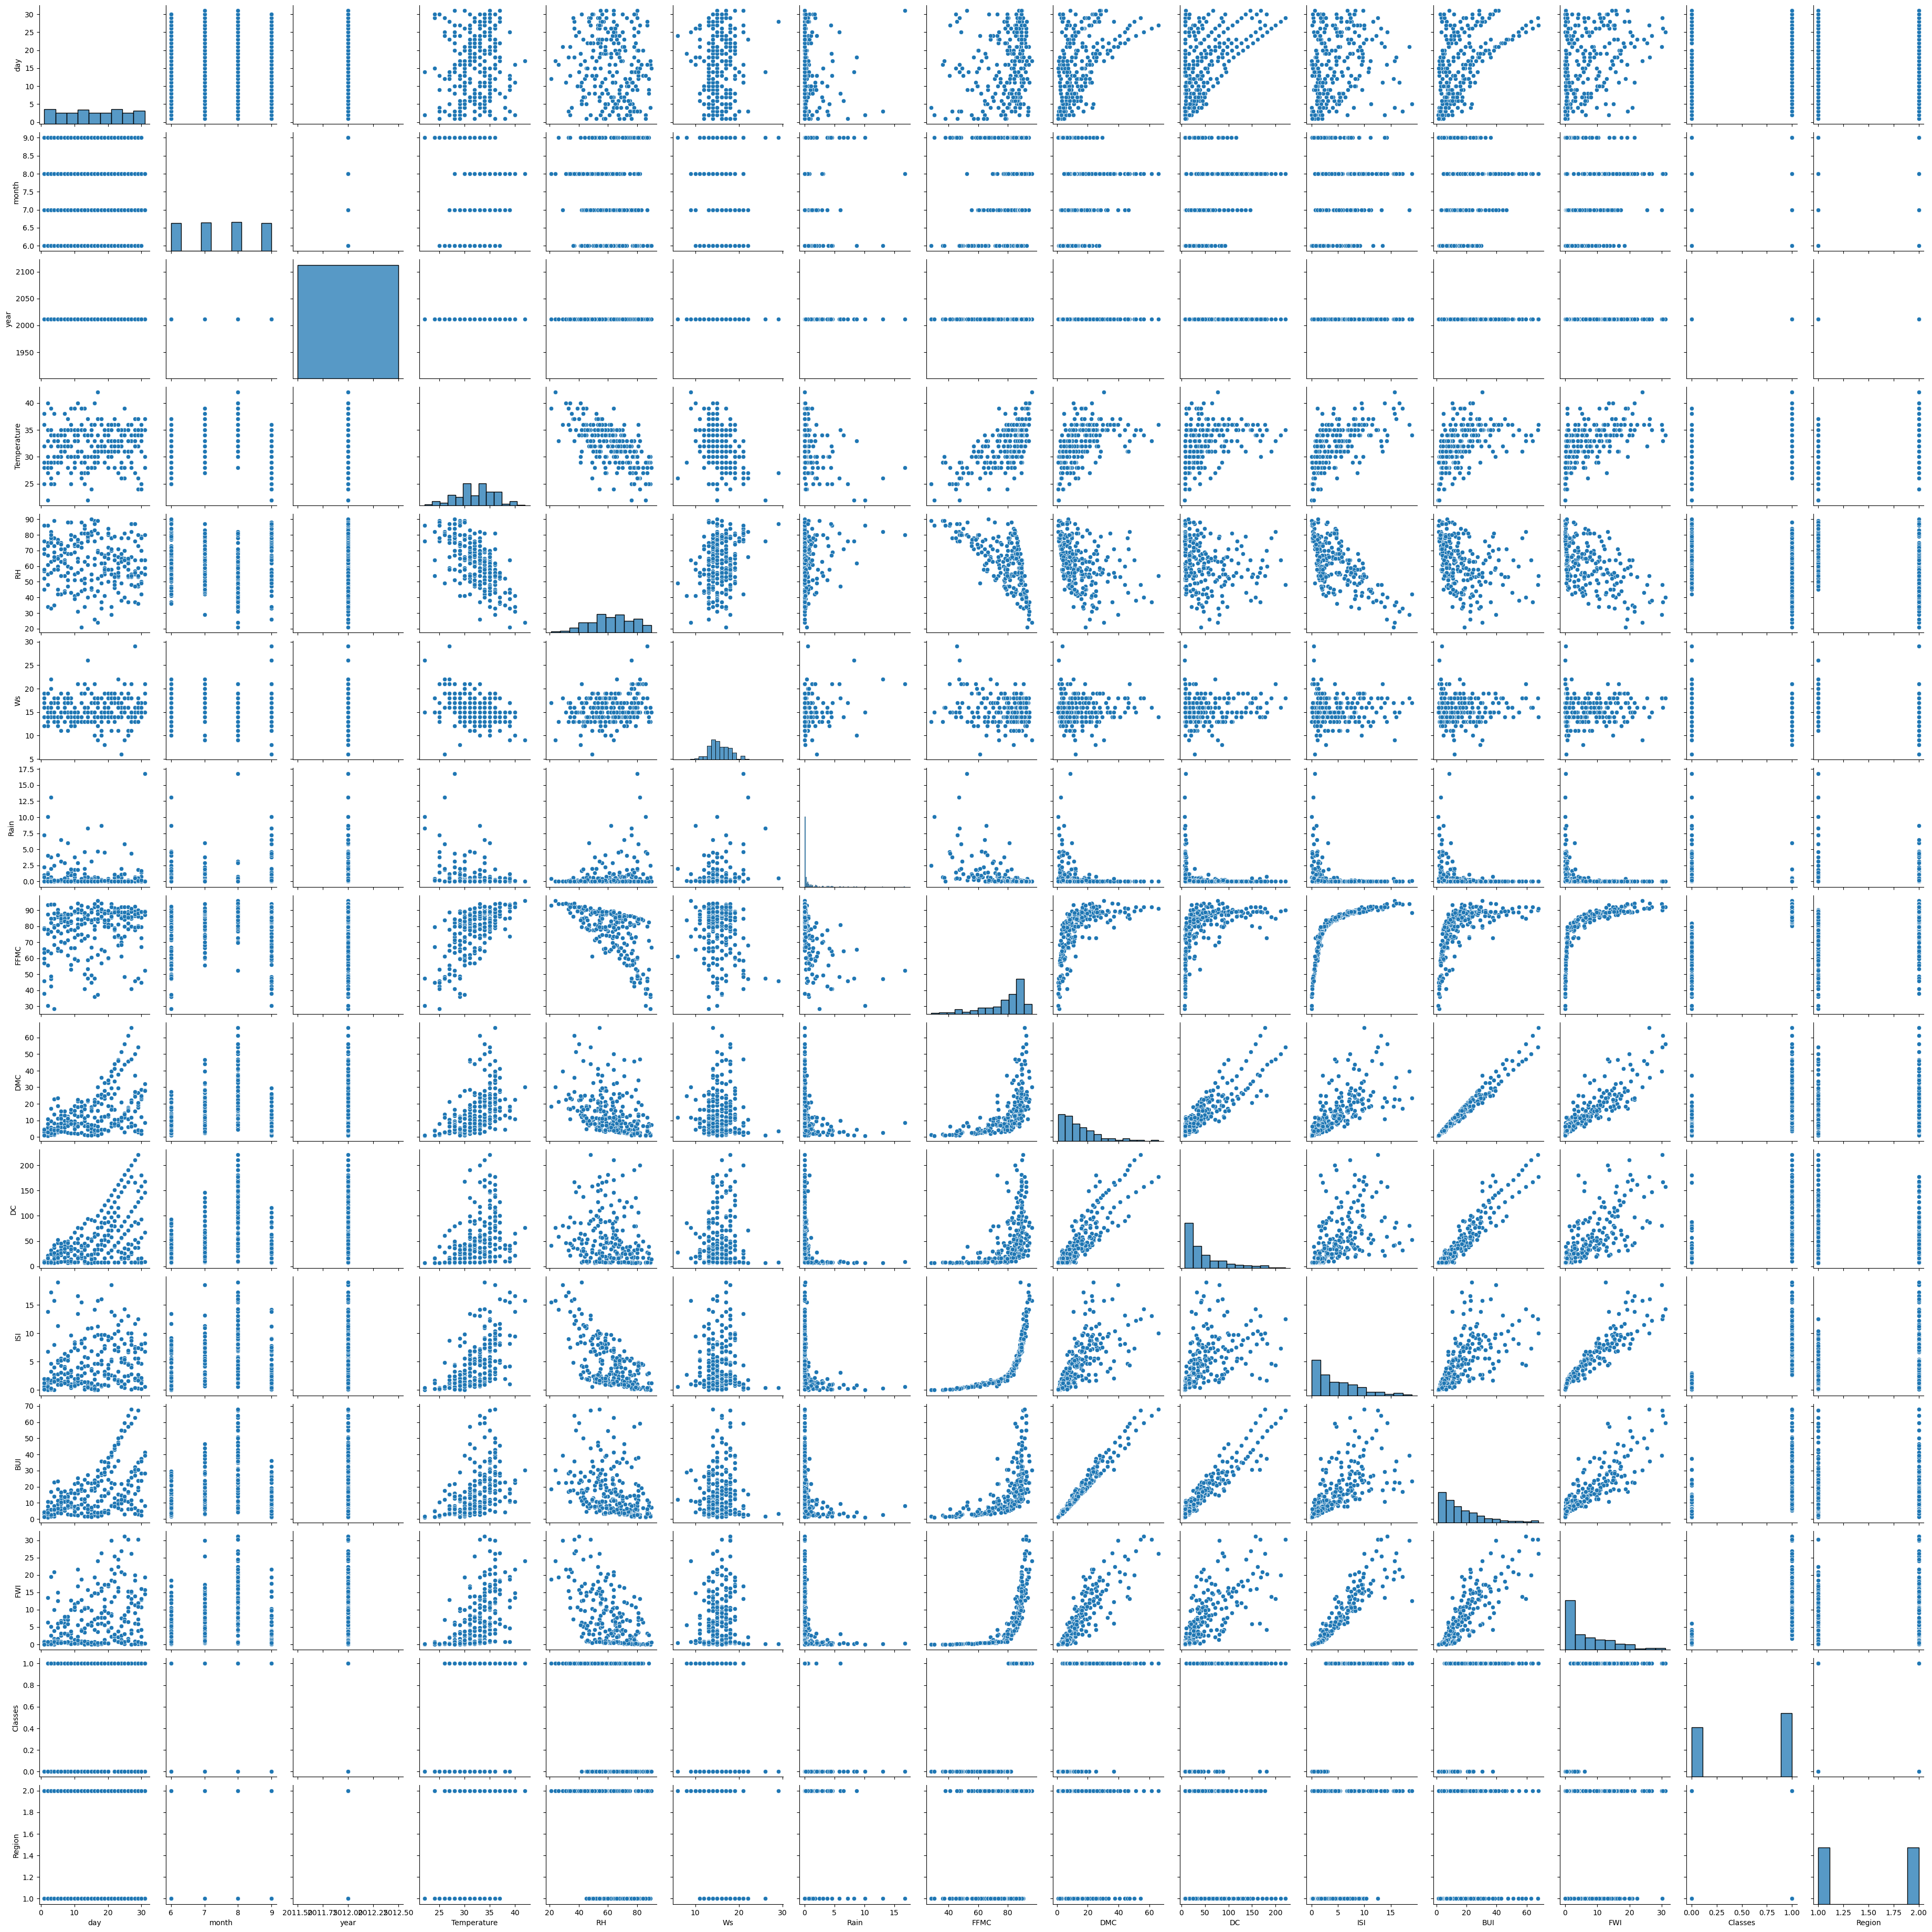

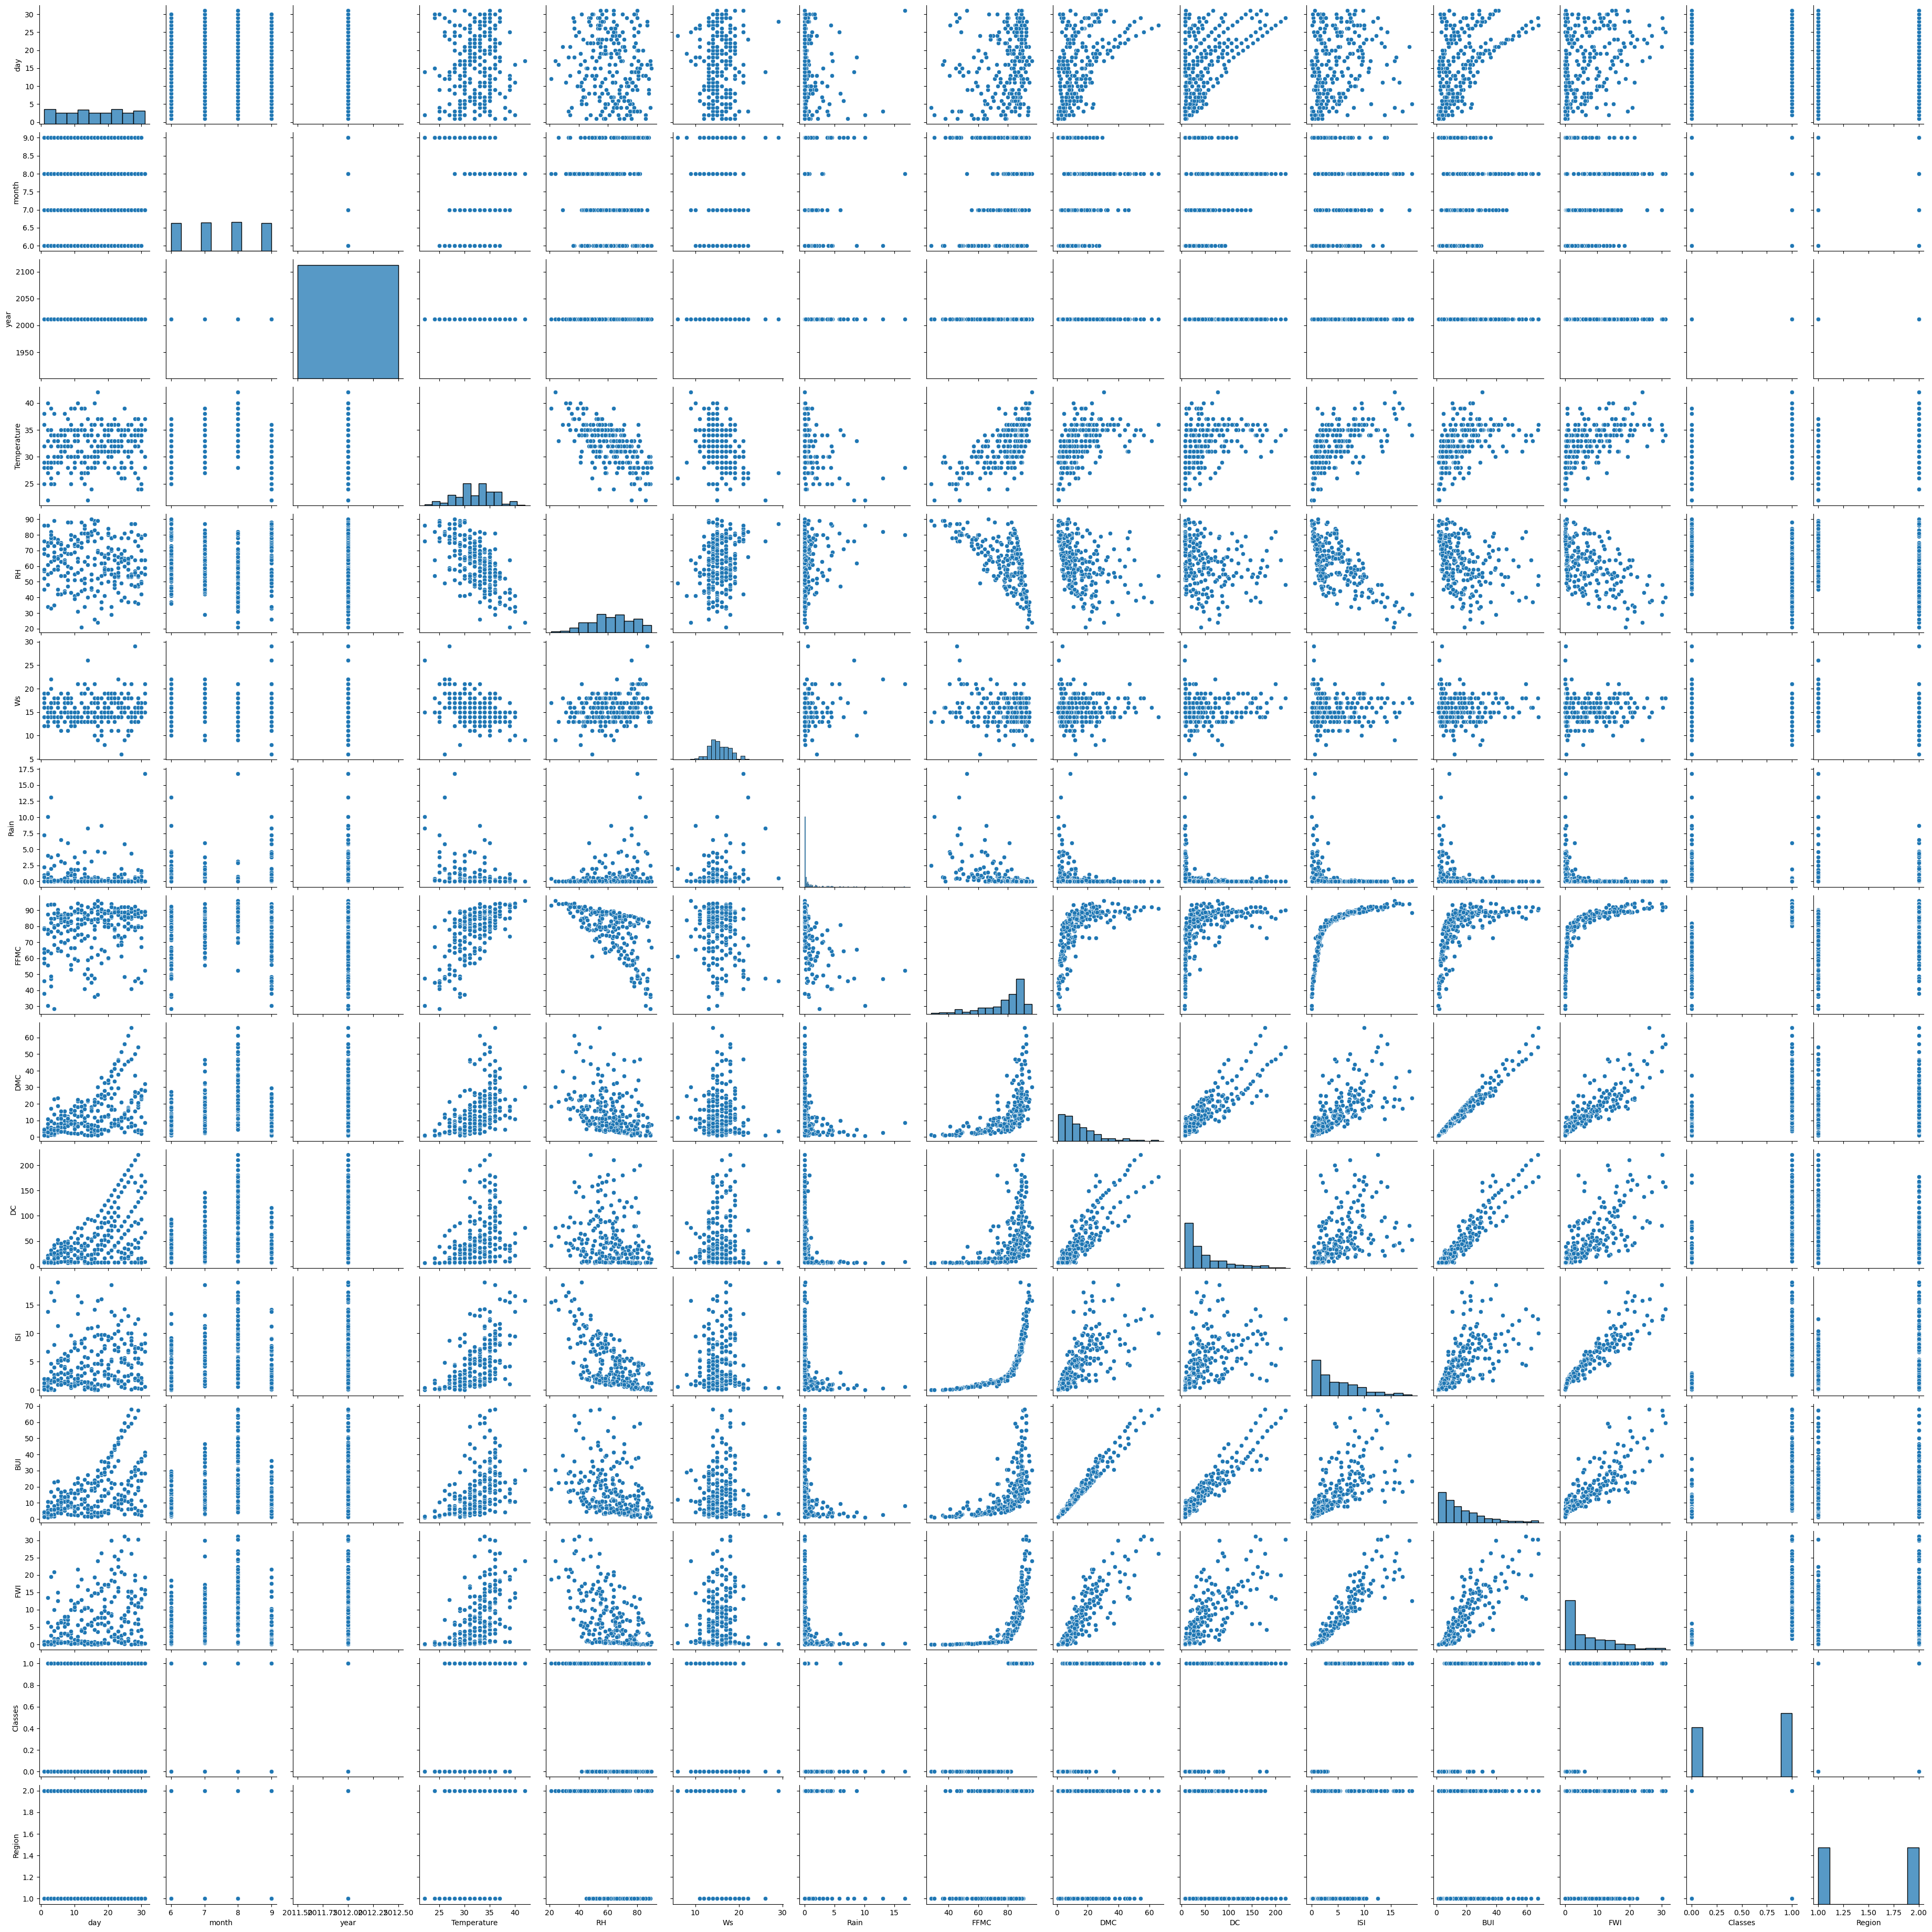

In [158]:
sns.pairplot(df)
plt.show()

### Data Cleaning and Preparation 
*By Abby*

From the data quality check we realized that:

1. Many columns were not a numeric type. So, we converted the datatype of these columns to numeric.

2. The dataset was incorrectly labelled by extra rows that were unnecessary with missing values. They did not hold any fire data but were used as labels. The first 122 rows the data set were of Bejaia, and the rows 123 onwards was for Sidi-Bel Abbes. To correct this labelling issue, we assigned each region by a number, 1 or 2. 

3. Our data is mostly very clean. 

4. There were a lot of unecessary spacing in the values, so we needed to strip them. 

5. Only two missing values, one for the aforementioned row, and one for an instance. We dropped it. 

6. We need ssigned numbers for whether a fire occurred or not, 0 for no fire and 1 for fire. 

7. From the summary provided in the code below, we see that there is no data that seems out of the ordinary to raise concern. 

The code below implements the above cleaning.


In [147]:
#dropping missing vals
df.dropna(inplace=True)

# dropping a row that was just for labelling
df = df.drop(index=123,axis=0)

In [148]:
# Region 1 and 2
# Region 1 is Bejaia and Region 2 is Sidi Bel-Abbes 
df.loc[:122,'Region']=1
df.loc[122:,'Region']=2
df[['Region']] = df[['Region']].astype(int)
df.columns


Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

In [149]:
# getting rid of column names weird spacing
df.columns=df.columns.str.strip()
df.columns 

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [150]:
#Converting Not fire/Fire (with unnecessary spacing) to 0 and 1
print(df['Classes'].unique())

['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire '
 'not fire     ' 'not fire    ']


In [151]:
df.Classes=df.Classes.str.strip()
df.Classes.unique()

array(['not fire', 'fire'], dtype=object)

In [152]:
df.dtypes

day            object
month          object
year           object
Temperature    object
RH             object
Ws             object
Rain           object
FFMC           object
DMC            object
DC             object
ISI            object
BUI            object
FWI            object
Classes        object
Region          int64
dtype: object

In [153]:
# No null values 
df.isnull().sum()

day            0
month          0
year           0
Temperature    0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
Classes        0
Region         0
dtype: int64

In [154]:
# No duplicates 
df.duplicated().sum()

0

In [155]:
df['Classes'] = df['Classes'].replace('not fire', 0)
df['Classes'] = df['Classes'].replace('fire', 1)
df.Classes.unique()

array([0, 1])

In [156]:
# converting column data types
df['DC']=df['DC'].astype('float')
df['ISI']=df['ISI'].astype('float')
df['BUI']=df['BUI'].astype('float')
df['FWI']=df['FWI'].astype('float')
df['day']=df['day'].astype('int')
df['month']=df['month'].astype('int')
df['year']=df['year'].astype('int')
df['Temperature']=df['Temperature'].astype('int')
df['RH']=df['RH'].astype('int')
df['Ws']=df['Ws'].astype('int')
df['Rain']=df['Rain'].astype('float')
df['FFMC']=df['FFMC'].astype('float')
df['DMC']=df['DMC'].astype('float')
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,1
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,1
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,1
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,1
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,26,9,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,2
242,27,9,2012,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0,2
243,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0,2
244,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0,2


In [127]:
# Shuffling the dataset
df = df.sample(frac=1, random_state=42)
df = df_shuffled.reset_index(drop=True)

In [161]:
summary = df.describe(include='all')

missing_values = df.isnull().sum()

summary.loc['missing_values'] = missing_values

cat_dist = pd.DataFrame(columns=['unique_values', 'frequency'])

for column in df.columns:
    if df[column].dtype == np.object:
        unique_values = df[column].nunique()
        frequency = df[column].value_counts(normalize=True)
        cat_dist.loc[column] = [unique_values, frequency]

summary

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
count,243.000000,243.000000,243.0,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000
mean,15.761317,7.502058,2012.0,32.152263,62.041152,15.493827,0.762963,77.842387,14.680658,49.430864,4.742387,16.690535,7.035391,0.563786,1.497942
std,8.842552,1.114793,0.0,3.628039,14.828160,2.811385,2.003207,14.349641,12.393040,47.665606,4.154234,14.228421,7.440568,0.496938,0.501028
min,1.000000,6.000000,2012.0,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000,0.000000,1.000000
25%,8.000000,7.000000,2012.0,30.000000,52.500000,14.000000,0.000000,71.850000,5.800000,12.350000,1.400000,6.000000,0.700000,0.000000,1.000000
50%,16.000000,8.000000,2012.0,32.000000,63.000000,15.000000,0.000000,83.300000,11.300000,33.100000,3.500000,12.400000,4.200000,1.000000,1.000000
75%,23.000000,8.000000,2012.0,35.000000,73.500000,17.000000,0.500000,88.300000,20.800000,69.100000,7.250000,22.650000,11.450000,1.000000,2.000000
max,31.000000,9.000000,2012.0,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,220.400000,19.000000,68.000000,31.100000,1.000000,2.000000
missing_values,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [164]:
from sklearn.model_selection import train_test_split

#Creating training and test datasets
np.random.seed(2)
train = df.sample(round(df.shape[0]*0.7))
test = df.drop(train.index)

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.